## Predicting Formula 1 Race Outcomes and Evaluating Betting Performance

### Index

1. **Problem Definition**
2. **Data Collection and Preprocessing**
3. **Exploratory Data Analysis (EDA)**
4. **Feature Engineering**
5. **Modeling Approaches**
   - 5.1. Predicting the Race Winner (Classification)
   - 5.2. Predicting Race Positions (Regression)
   - 5.3. Predicting Race Positions (Multiclass Classification)
6. **Model Evaluation and Comparison**
7. **Betting Odds Analysis**
   - 7.1. Collecting Betting Odds
   - 7.2. Simulating Betting Outcomes
   - 7.3. Evaluating Profitability of Predictions
8. **Insights and Conclusions**
9. **Future Work**


In [1]:
import numpy as np
import pandas as pd

In [2]:
circuits = pd.read_csv('data/circuits.csv')
constructor_standings = pd.read_csv('data/constructor_standings.csv')
constructors = pd.read_csv('data/constructors.csv')
driver_standings = pd.read_csv('data/driver_standings.csv')
drivers = pd.read_csv('data/drivers.csv')
qualifying = pd.read_csv('data/qualifying.csv')
races = pd.read_csv('data/races.csv')
results = pd.read_csv('data/results.csv')

In [3]:
print("Variable types in circuits:\n", circuits.dtypes)
print("\nVariable types in constructor_standings:\n", constructor_standings.dtypes)
print("\nVariable types in constructors:\n", constructors.dtypes)
print("\nVariable types in driver_standings:\n", driver_standings.dtypes)
print("\nVariable types in drivers:\n", drivers.dtypes)
print("\nVariable types in qualifying:\n", qualifying.dtypes)
print("\nVariable types in races:\n", races.dtypes)
print("\nVariable types in results:\n", results.dtypes)

Variable types in circuits:
 circuitId       int64
circuitRef     object
name           object
location       object
country        object
lat           float64
lng           float64
alt             int64
url            object
dtype: object

Variable types in constructor_standings:
 constructorStandingsId      int64
raceId                      int64
constructorId               int64
points                    float64
position                    int64
positionText               object
wins                        int64
dtype: object

Variable types in constructors:
 constructorId      int64
constructorRef    object
name              object
nationality       object
url               object
dtype: object

Variable types in driver_standings:
 driverStandingsId      int64
raceId                 int64
driverId               int64
points               float64
position               int64
positionText          object
wins                   int64
dtype: object

Variable types in drivers:
 driverI

In [4]:
print("Shape of circuits:", circuits.shape)
print("Shape of constructor_standings:", constructor_standings.shape)
print("Shape of constructors:", constructors.shape)
print("Shape of driver_standings:", driver_standings.shape)
print("Shape of drivers:", drivers.shape)
print("Shape of qualifying:", qualifying.shape)
print("Shape of races:", races.shape)
print("Shape of results:", results.shape)

Shape of circuits: (77, 9)
Shape of constructor_standings: (13271, 7)
Shape of constructors: (212, 5)
Shape of driver_standings: (34595, 7)
Shape of drivers: (859, 9)
Shape of qualifying: (10254, 9)
Shape of races: (1125, 18)
Shape of results: (26519, 18)


Key Observations
Datasets and Sizes:

Small datasets: circuits, constructors, drivers, status.
Medium datasets: constructor_results, constructor_standings, races, results, qualifying, sprint_results.
Large datasets: lap_times, pit_stops.
Columns with IDs:

raceId, driverId, constructorId are central identifiers linking multiple datasets.
Missing Data:

qualifying has missing values in q2 and q3.
races has placeholders like \N in session times.

Common Relationships:

races connects with circuits (via circuitId), results and qualifying (via raceId).
drivers and constructors connect with results (via driverId, constructorId).
lap_times and pit_stops detail race events (via raceId, driverId).

In [5]:
# Merge datasets using INNER JOINs with custom suffixes
merged_data = pd.merge(races, circuits, on="circuitId", how="inner", suffixes=('_races', '_circuits'))
merged_data = pd.merge(merged_data, results, on="raceId", how="inner", suffixes=('', '_results'))
merged_data = pd.merge(merged_data, drivers, on="driverId", how="inner", suffixes=('', '_drivers'))
merged_data = pd.merge(merged_data, constructors, on="constructorId", how="inner", suffixes=('', '_constructors'))
merged_data = pd.merge(merged_data, driver_standings, on=["raceId", "driverId"], how="inner", suffixes=('', '_driver_standings'))
merged_data = pd.merge(merged_data, constructor_standings, on=["raceId", "constructorId"], how="inner", suffixes=('', '_constructor_standings'))
merged_data = pd.merge(merged_data, qualifying, on=["raceId", "driverId"], how="inner", suffixes=('', '_qualifying'))


In [6]:
merged_data.to_csv('data/merged_data.csv', index=False)

In [7]:
merged_data.columns

Index(['raceId', 'year', 'round', 'circuitId', 'name_races', 'date', 'time',
       'url_races', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date',
       'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time',
       'circuitRef', 'name_circuits', 'location', 'country', 'lat', 'lng',
       'alt', 'url_circuits', 'resultId', 'driverId', 'constructorId',
       'number', 'grid', 'position', 'positionText', 'positionOrder', 'points',
       'laps', 'time_results', 'milliseconds', 'fastestLap', 'rank',
       'fastestLapTime', 'fastestLapSpeed', 'statusId', 'driverRef',
       'number_drivers', 'code', 'forename', 'surname', 'dob', 'nationality',
       'url', 'constructorRef', 'name', 'nationality_constructors',
       'url_constructors', 'driverStandingsId', 'points_driver_standings',
       'position_driver_standings', 'positionText_driver_standings', 'wins',
       'constructorStandingsId', 'points_constructor_standings',
       'position_constructor_standings'

In [8]:
# Columns to drop
columns_to_drop = [
    'driverId', 'constructorId', 'statusId', 'qualifyId', 'constructorResultsId', 'constructorStandingsId', 'driverStandingsId',
    'url_races', 'tiime', 'url_circuits', 'number', 'url_results', 'url', 'code', 'url_drivers', 'resultId',
    'name_circuits', 'location', 'lat', 'lng', 'alt', 'url_drivers', 'constructorStandingsId', 'time', 'driverRef',
    'number', 'code', 'url_constructors', 'url_driver_standings', 'positionText', 'positionOrder', 'position_qualifying',
    'time_results', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'number_drivers',
    'positionText_driver_standings', 'constructorId_qualifying', 'number_qualifying', 'position_qualifying',
    'positionText_constructor_standings', 'positionOrder_constructor_standings', 'points_constructor_standings',
    'wins_constructor_standings', 'positionText_constructor_standings', 'constructorRef', 'position_constructor_standings',
    'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time'
]


# Lists of status IDs
driver_error_status_ids = [3, 4, 20, 28, 68, 73, 82, 89, 100, 104, 107, 130, 139]
constructor_error_status_ids = [
    5, 6, 7, 8, 9, 10, 21, 22, 23, 24, 25, 26, 27, 29, 30, 32, 33, 34, 35, 36, 37,
    38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 51, 59, 60, 61, 63, 64, 65, 66,
    67, 69, 70, 71, 72, 74, 75, 76, 79, 80, 83, 84, 86, 87, 91, 94, 95, 98, 99,
    101, 102, 103, 105, 106, 108, 109, 110, 121, 126, 129, 131, 132, 135, 140, 141
]
finished_status_ids = [
    1, 11, 12, 13, 14, 15, 16, 17, 18, 19, 45, 50, 53, 55, 88,
    111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123,
    124, 125, 127, 128, 133, 134
]

# Initialize columns with zeros
merged_data['driver_dnf'] = 0
merged_data['constructor_dnf'] = 0

# Set driver_dnf to 1 where statusId is a driver error
merged_data.loc[merged_data['statusId'].isin(driver_error_status_ids), 'driver_dnf'] = 1

# Set constructor_dnf to 1 where statusId is a constructor error
merged_data.loc[merged_data['statusId'].isin(constructor_error_status_ids), 'constructor_dnf'] = 1

# Ensure that drivers who finished the race have zeros in both columns
merged_data.loc[merged_data['statusId'].isin(finished_status_ids), ['driver_dnf', 'constructor_dnf']] = 0

# Drop the specified columns
cleaned_data = merged_data.drop(columns=columns_to_drop, errors='ignore')



In [9]:
cleaned_data.head()

,raceId,year,round,circuitId,name_races,date,circuitRef,country,grid,position,...,name,nationality_constructors,points_driver_standings,position_driver_standings,wins,q1,q2,q3,driver_dnf,constructor_dnf
0,1,2009,1,1,Australian Grand Prix,2009-03-29,albert_park,Australia,1,1,...,Brawn,British,10.0,1,1,1:25.211,1:24.855,1:26.202,0,0
1,1,2009,1,1,Australian Grand Prix,2009-03-29,albert_park,Australia,2,2,...,Brawn,British,8.0,2,0,1:25.006,1:24.783,1:26.505,0,0
2,2,2009,2,2,Malaysian Grand Prix,2009-04-05,sepang,Malaysia,1,1,...,Brawn,British,15.0,1,2,1:35.058,1:33.784,1:35.181,0,0
3,2,2009,2,2,Malaysian Grand Prix,2009-04-05,sepang,Malaysia,8,5,...,Brawn,British,10.0,2,0,1:34.681,1:34.387,1:35.651,0,0
4,3,2009,3,17,Chinese Grand Prix,2009-04-19,shanghai,China,5,3,...,Brawn,British,21.0,1,2,1:35.533,1:35.556,1:36.532,0,0


In [10]:
cleaned_data.rename(columns={
    'name_races': 'GP_name',
    'nationality': 'driver_nationality',
    'points_driver_standings': 'total_points',
    'position_driver_standings': 'championship_position',
    'name': 'constructor_name',
    'wins' : 'number_wins'
}, inplace = True)

# Display the first 5 rows of the cleaned data
cleaned_data.head()


,raceId,year,round,circuitId,GP_name,date,circuitRef,country,grid,position,...,constructor_name,nationality_constructors,total_points,championship_position,number_wins,q1,q2,q3,driver_dnf,constructor_dnf
0,1,2009,1,1,Australian Grand Prix,2009-03-29,albert_park,Australia,1,1,...,Brawn,British,10.0,1,1,1:25.211,1:24.855,1:26.202,0,0
1,1,2009,1,1,Australian Grand Prix,2009-03-29,albert_park,Australia,2,2,...,Brawn,British,8.0,2,0,1:25.006,1:24.783,1:26.505,0,0
2,2,2009,2,2,Malaysian Grand Prix,2009-04-05,sepang,Malaysia,1,1,...,Brawn,British,15.0,1,2,1:35.058,1:33.784,1:35.181,0,0
3,2,2009,2,2,Malaysian Grand Prix,2009-04-05,sepang,Malaysia,8,5,...,Brawn,British,10.0,2,0,1:34.681,1:34.387,1:35.651,0,0
4,3,2009,3,17,Chinese Grand Prix,2009-04-19,shanghai,China,5,3,...,Brawn,British,21.0,1,2,1:35.533,1:35.556,1:36.532,0,0


In [11]:
cleaned_data.columns

Index(['raceId', 'year', 'round', 'circuitId', 'GP_name', 'date', 'circuitRef',
       'country', 'grid', 'position', 'points', 'laps', 'forename', 'surname',
       'dob', 'driver_nationality', 'constructor_name',
       'nationality_constructors', 'total_points', 'championship_position',
       'number_wins', 'q1', 'q2', 'q3', 'driver_dnf', 'constructor_dnf'],
      dtype='object')

In [12]:
# Combine 'forename' and 'surname' into a single column called 'driver_name'
cleaned_data['driver_name'] = cleaned_data['forename'] + ' ' + cleaned_data['surname']

# Drop the original 'forename' and 'surname' columns as they are no longer needed
cleaned_data = cleaned_data.drop(columns=['forename', 'surname'], errors='ignore')

#tranform the 'dob' and 'date' column to datetime
cleaned_data['dob'] = pd.to_datetime(cleaned_data['dob'])
cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])

cleaned_data['age_at_gp_in_days'] = abs(cleaned_data['dob']-cleaned_data['date'])
cleaned_data['age_at_gp_in_days'] = cleaned_data['age_at_gp_in_days'].apply(lambda x: str(x).split(' ')[0])


# Display the first few rows to confirm the changes
cleaned_data.head()


,raceId,year,round,circuitId,GP_name,date,circuitRef,country,grid,position,...,total_points,championship_position,number_wins,q1,q2,q3,driver_dnf,constructor_dnf,driver_name,age_at_gp_in_days
0,1,2009,1,1,Australian Grand Prix,2009-03-29,albert_park,Australia,1,1,...,10.0,1,1,1:25.211,1:24.855,1:26.202,0,0,Jenson Button,10662
1,1,2009,1,1,Australian Grand Prix,2009-03-29,albert_park,Australia,2,2,...,8.0,2,0,1:25.006,1:24.783,1:26.505,0,0,Rubens Barrichello,13459
2,2,2009,2,2,Malaysian Grand Prix,2009-04-05,sepang,Malaysia,1,1,...,15.0,1,2,1:35.058,1:33.784,1:35.181,0,0,Jenson Button,10669
3,2,2009,2,2,Malaysian Grand Prix,2009-04-05,sepang,Malaysia,8,5,...,10.0,2,0,1:34.681,1:34.387,1:35.651,0,0,Rubens Barrichello,13466
4,3,2009,3,17,Chinese Grand Prix,2009-04-19,shanghai,China,5,3,...,21.0,1,2,1:35.533,1:35.556,1:36.532,0,0,Jenson Button,10683


In [13]:
cleaned_data = cleaned_data.sort_values(by=['year', 'round'])
cleaned_data.head()

,raceId,year,round,circuitId,GP_name,date,circuitRef,country,grid,position,...,total_points,championship_position,number_wins,q1,q2,q3,driver_dnf,constructor_dnf,driver_name,age_at_gp_in_days
829,257,1994,1,18,Brazilian Grand Prix,1994-03-27,interlagos,Brazil,2,1,...,10.0,1,1,1:16.290,\N,\N,0,0,Michael Schumacher,9214
830,257,1994,1,18,Brazilian Grand Prix,1994-03-27,interlagos,Brazil,9,\N,...,0.0,16,0,1:18.183,\N,\N,1,0,Jos Verstappen,8058
1525,257,1994,1,18,Brazilian Grand Prix,1994-03-27,interlagos,Brazil,4,2,...,6.0,2,0,1:17.554,\N,\N,0,0,Damon Hill,12244
1526,257,1994,1,18,Brazilian Grand Prix,1994-03-27,interlagos,Brazil,1,\N,...,0.0,13,0,1:15.962,\N,\N,1,0,Ayrton Senna,12424
2528,257,1994,1,18,Brazilian Grand Prix,1994-03-27,interlagos,Brazil,8,\N,...,0.0,21,0,1:18.122,\N,\N,0,1,Mika Häkkinen,9311


In [14]:
cleaned_data.to_csv('data/cleaned_data.csv', index=False)

### EDA

In [15]:
# Step 1: Understand the Data Structure

# Display the shape of the dataset
dataset_shape = cleaned_data.shape

# List column names and their data types
column_info = cleaned_data.dtypes

# Sample unique values for each column
unique_values_sample = cleaned_data.nunique()

# Check for missing values in each column
missing_values = cleaned_data.isnull().sum()

# Compile the information into a summary table
data_overview = pd.DataFrame({
    "Data Type": column_info,
    "Unique Values": unique_values_sample,
    "Missing Values": missing_values,
    "Missing %": (missing_values / dataset_shape[0]) * 100
})


dataset_shape, data_overview


((10011, 26),
                                Data Type  Unique Values  Missing Values  \
 raceId                             int64            482               0   
 year                               int64             31               0   
 round                              int64             22               0   
 circuitId                          int64             43               0   
 GP_name                           object             43               0   
 date                      datetime64[ns]            482               0   
 circuitRef                        object             43               0   
 country                           object             31               0   
 grid                               int64             27               0   
 position                          object             25               0   
 points                           float64             29               0   
 laps                               int64             85               0  

### Step 1: Data Structure Analysis - Observations:

- Dataset Size: The dataset contains 8,131 rows and 20 columns.
- Column Overview: Columns include a mix of numerical (e.g., grid, laps), categorical (e.g., GP_name, position), and datetime (e.g., date, dob) types.
- Unique Values: Several columns, such as driver_name and constructor_name, have high cardinality, indicating diversity in data points.
- Missing Data: There are no missing values in the dataset.

In [16]:
# Step 2: Summary Statistics

# Generate descriptive statistics for numeric columns
numeric_summary = cleaned_data.describe()

# Display statistics for categorical columns
categorical_summary = cleaned_data.select_dtypes(include=['object']).describe()

numeric_summary, categorical_summary


(            raceId          year         round     circuitId          grid  \
 count  10011.00000  10011.000000  10011.000000  10011.000000  10011.000000   
 mean     623.19059   2011.222256      9.839576     19.672161     10.982020   
 std      425.01072      8.362961      5.574044     20.538402      6.271216   
 min        1.00000   1994.000000      1.000000      1.000000      0.000000   
 25%      156.00000   2006.000000      5.000000      7.000000      6.000000   
 50%      870.00000   2012.000000     10.000000     13.000000     11.000000   
 75%     1000.00000   2018.000000     14.000000     22.000000     16.000000   
 max     1132.00000   2024.000000     22.000000     80.000000     26.000000   
 
              points          laps  total_points  championship_position  \
 count  10011.000000  10011.000000  10011.000000           10011.000000   
 mean       3.614424     52.098691     36.577515              11.388672   
 std        6.067520     19.364387     61.251544              

### Step 2: Summary Statistics
Key Insights:

- Numerical Summary:
    - Columns like grid and laps have wide ranges, which suggests varying conditions across races.
    - Some variables like total_points and championship_position could potentially be strong predictors for the winner.

- Categorical Summary:
    - GP_name has 31 unique values, which corresponds to different Grand Prix events.
    - driver_name has 156 unique entries, reflecting a diverse set of participants.
    - Variables such as q1, q2, and q3 include significant amounts of non-informative data (\N), which may require cleaning or imputation.

In [17]:
# Step 1: Basic Statistics
# Summary statistics of numerical features
basic_stats = cleaned_data.describe()

# Step 2: Target Analysis - Distribution of 'position' and 'dnf'
position_distribution = cleaned_data['position'].value_counts().sort_index()
dnf_distribution = cleaned_data['driver_dnf'].value_counts()

# Step 3: Feature Relationships
# Correlation between numerical features
correlation_matrix = cleaned_data.corr()


position_distribution, dnf_distribution, correlation_matrix


C:\Users\joelc\AppData\Local\Temp\ipykernel_14524\1373551995.py:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = cleaned_data.corr()


(1      482
 10     464
 11     453
 12     435
 13     421
 14     391
 15     363
 16     313
 17     264
 18     182
 19     115
 2      482
 20      63
 21      29
 22      16
 23       5
 24       1
 3      482
 4      481
 5      481
 6      482
 7      479
 8      477
 9      474
 \N    2176
 Name: position, dtype: int64,
 0    9055
 1     956
 Name: driver_dnf, dtype: int64,
                          raceId      year     round  circuitId      grid  \
 raceId                 1.000000  0.832957  0.131232   0.315870 -0.042758   
 year                   0.832957  1.000000  0.141944   0.277979 -0.084439   
 round                  0.131232  0.141944  1.000000   0.275521 -0.000294   
 circuitId              0.315870  0.277979  0.275521   1.000000 -0.028938   
 grid                  -0.042758 -0.084439 -0.000294  -0.028938  1.000000   
 points                 0.240505  0.236270  0.032468   0.069894 -0.556167   
 laps                   0.078172  0.115049 -0.002012  -0.001572 -0.117182  

In [18]:
# Step 1: Handle the `position` column
# Replace '\N' with -1 to represent DNFs and convert the column to numeric
cleaned_data['position'] = cleaned_data['position'].replace('\\N', -1).astype(int)

# Step 2: Add a `winner` column
# Create a new column where 1 indicates the driver who finished first, 0 otherwise
cleaned_data['winner'] = (cleaned_data['position'] == 1).astype(int)

# Display the updated dataset structure and a sample to confirm changes
updated_sample = cleaned_data[['raceId', 'position', 'winner']].head()

updated_sample

,raceId,position,winner
829,257,1,1
830,257,-1,0
1525,257,2,0
1526,257,-1,0
2528,257,-1,0


In [19]:
# Replace '\N' with NaN for qualifying time columns
qualifying_columns = ['q1', 'q2', 'q3']
cleaned_data[qualifying_columns] = cleaned_data[qualifying_columns].replace('\\N', np.nan)

# Convert qualifying times to numerical format (seconds)
def time_to_seconds(time_str):
    if pd.isna(time_str):
        return np.nan
    try:
        minutes, seconds = map(float, time_str.split(':'))
        return minutes * 60 + seconds
    except:
        return np.nan

for col in qualifying_columns:
    cleaned_data[col] = cleaned_data[col].apply(time_to_seconds)

# Check the percentage of missing data in these columns
missing_qualifying_data = cleaned_data[qualifying_columns].isnull().mean() * 100

# Display the percentage of missing data
missing_qualifying_data

q1     1.488363
q2    43.592049
q3    65.018480
dtype: float64

Understanding the Problem
q1: Represents all drivers with qualifying times (minimal missing values).
q2: Only available for the top 15 fastest drivers from q1.
q3: Only available for the top 10 fastest drivers from q2.
These missing values are not random but instead a result of the qualification rules. They carry information about the driver's performance and ranking. For example:

A missing value in q2 means the driver did not make it past q1.
A missing value in q3 means the driver did not make it past q2.

In [20]:
# Hybrid Approach: Impute missing times and create progression indicators

# Define placeholder values for imputation
q2_placeholder = 200  # Represents a very high (bad) time for non-participants in q2
q3_placeholder = 300  # Represents a very high (bad) time for non-participants in q3

# Impute missing values with placeholders
cleaned_data['q2'] = cleaned_data['q2'].fillna(q2_placeholder)
cleaned_data['q3'] = cleaned_data['q3'].fillna(q3_placeholder)

# Create new columns for progression with 1 and 0
cleaned_data['passed_q1'] = (cleaned_data['q2'] != q2_placeholder).astype(int)
cleaned_data['passed_q2'] = (cleaned_data['q3'] != q3_placeholder).astype(int)

# Display the updated dataset structure and a sample
updated_summary = cleaned_data[['q1', 'q2', 'q3', 'passed_q1', 'passed_q2']].head()

updated_summary

,q1,q2,q3,passed_q1,passed_q2
829,76.290,200.0,300.0,0,0
830,78.183,200.0,300.0,0,0
1525,77.554,200.0,300.0,0,0
1526,75.962,200.0,300.0,0,0
2528,78.122,200.0,300.0,0,0


Reasoning Behind the Hybrid Approach
Preserving Predictive Power: By imputing missing values in q2 and q3 with high placeholders, the model retains the relative performance information inherent in the qualifying times.
Explicit Progression Encoding: The new boolean columns (passed_q1, passed_q2) explicitly indicate whether a driver progressed past each qualifying stage, adding clarity to the data for both interpretation and modeling.
Avoiding Data Loss: This method keeps all qualifying-related data while addressing missing values systematically, ensuring no information is discarded unnecessarily.

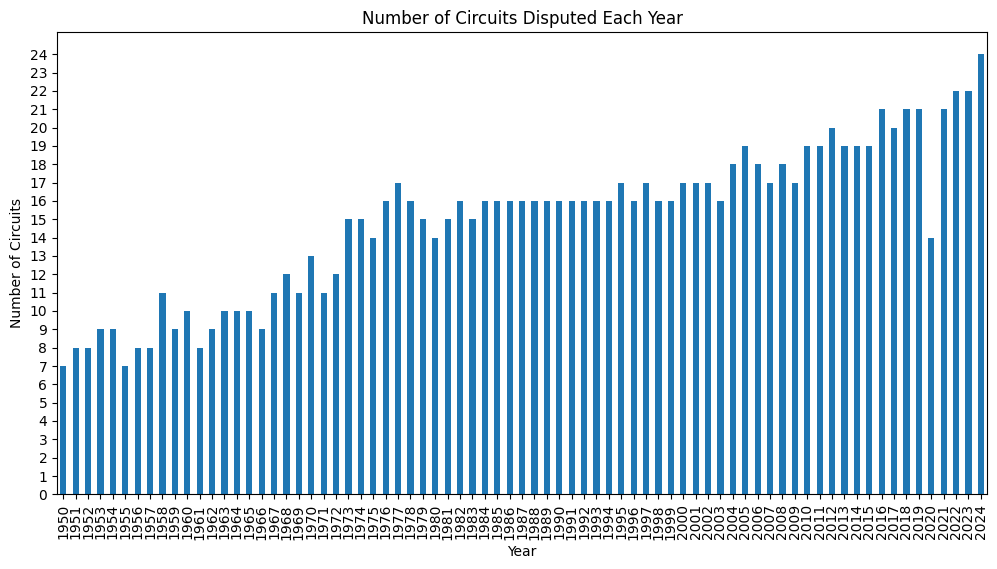

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by year and count the number of unique circuits
circuits_per_year = races.groupby('year')['circuitId'].nunique()

# Plot the results
plt.figure(figsize=(12, 6))
circuits_per_year.plot(kind='bar')
plt.title('Number of Circuits Disputed Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Circuits')
plt.yticks(range(0, int(circuits_per_year.max()) + 1))  # Set y-axis to integer values
plt.show()

In [22]:
import matplotlib.pyplot as plt

def plot_wins_driver(results, threshold=1):
    # Your existing data manipulation steps
    winners = results[results['positionOrder'] == 1].merge(races, on='raceId')
    wins_per_driver = winners.groupby(['driverId', 'year']).size().unstack(fill_value=0)

    # Calculate total wins per driver
    total_wins_per_driver = wins_per_driver.sum(axis=1)

    # Merge with drivers to get surnames
    total_wins_per_driver = total_wins_per_driver.reset_index().merge(drivers[['driverId', 'surname']], on='driverId')

    # Filter out drivers with 0 wins
    total_wins_per_driver = total_wins_per_driver[total_wins_per_driver[0] > threshold]

    # Plot the results
    plt.figure(figsize=(15, 6))  # Increase figure size for better spacing
    ax = total_wins_per_driver.set_index('surname')[0].sort_values(ascending=False).plot(kind='bar', color='blue')

    # Rotate x-axis labels for readability
    plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees and align them to the right
    plt.title('Total Wins Per Driver')
    plt.xlabel('Driver Surname')
    plt.ylabel('Number of Wins')
    plt.grid(axis='y')

    # Adjust layout to prevent clipping of labels
    plt.tight_layout()

    # Show the plot
    plt.show()

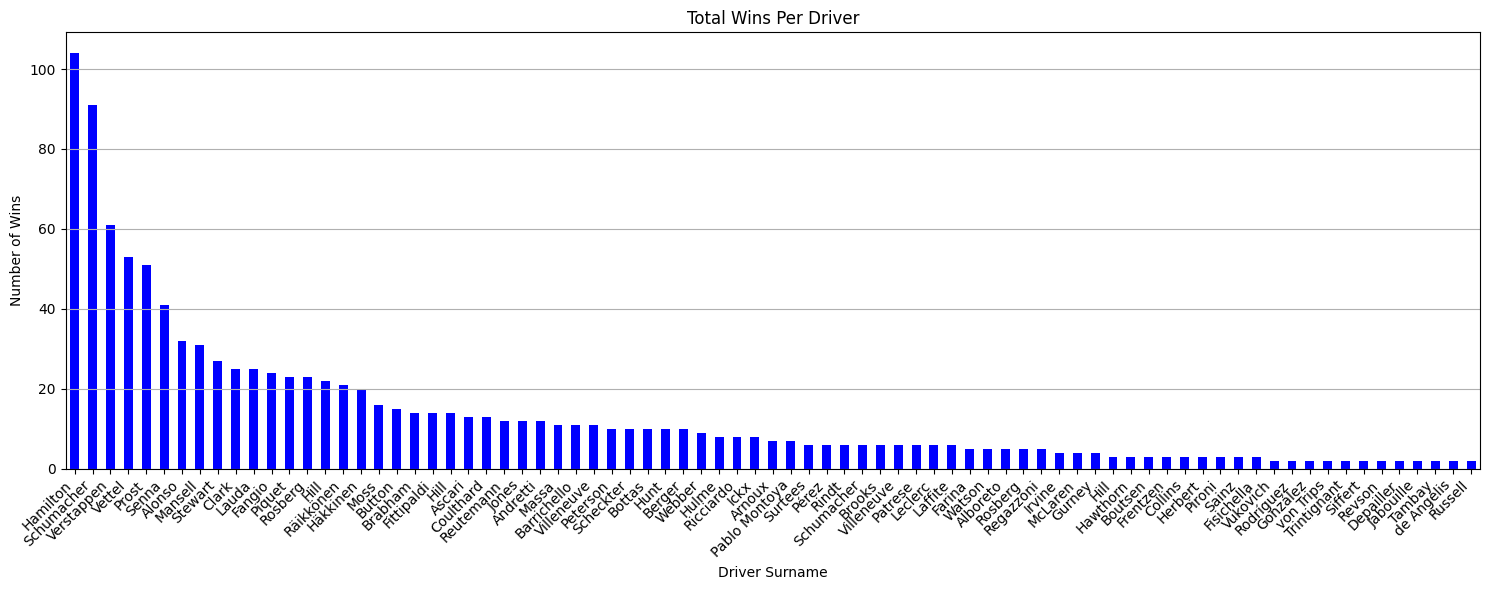

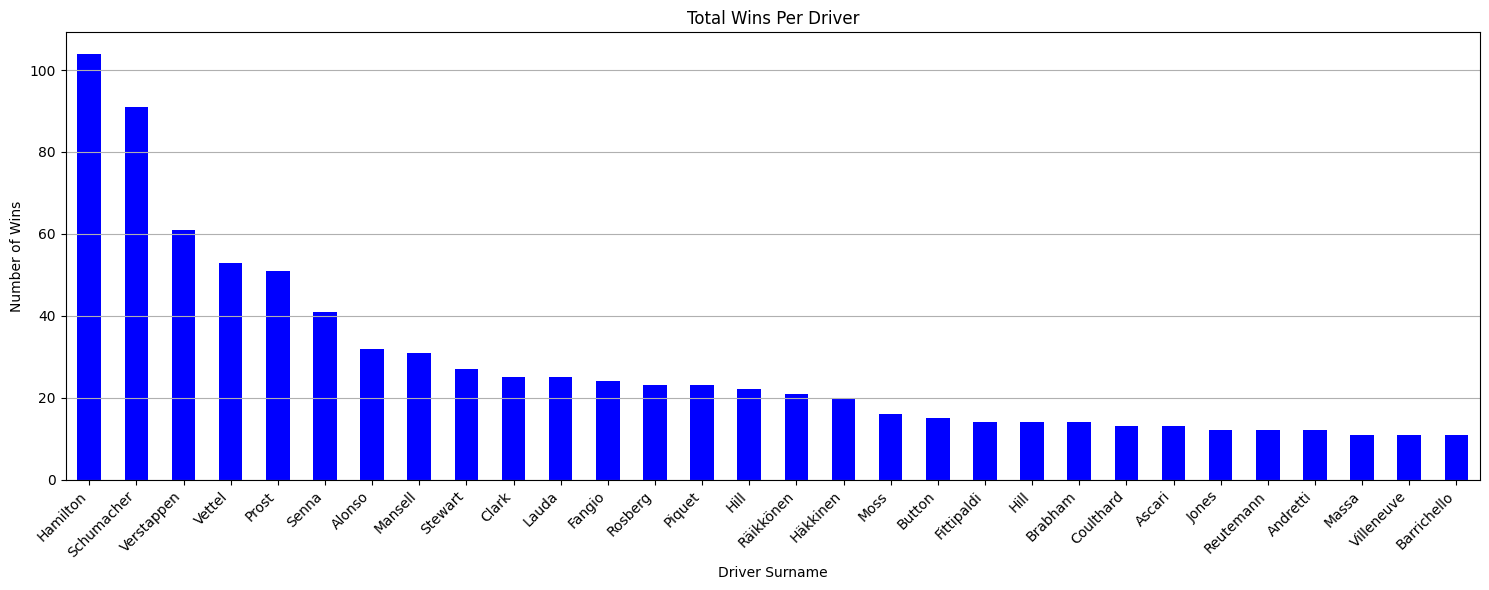

In [23]:
plot_wins_driver(results)
plot_wins_driver(results, threshold=10)

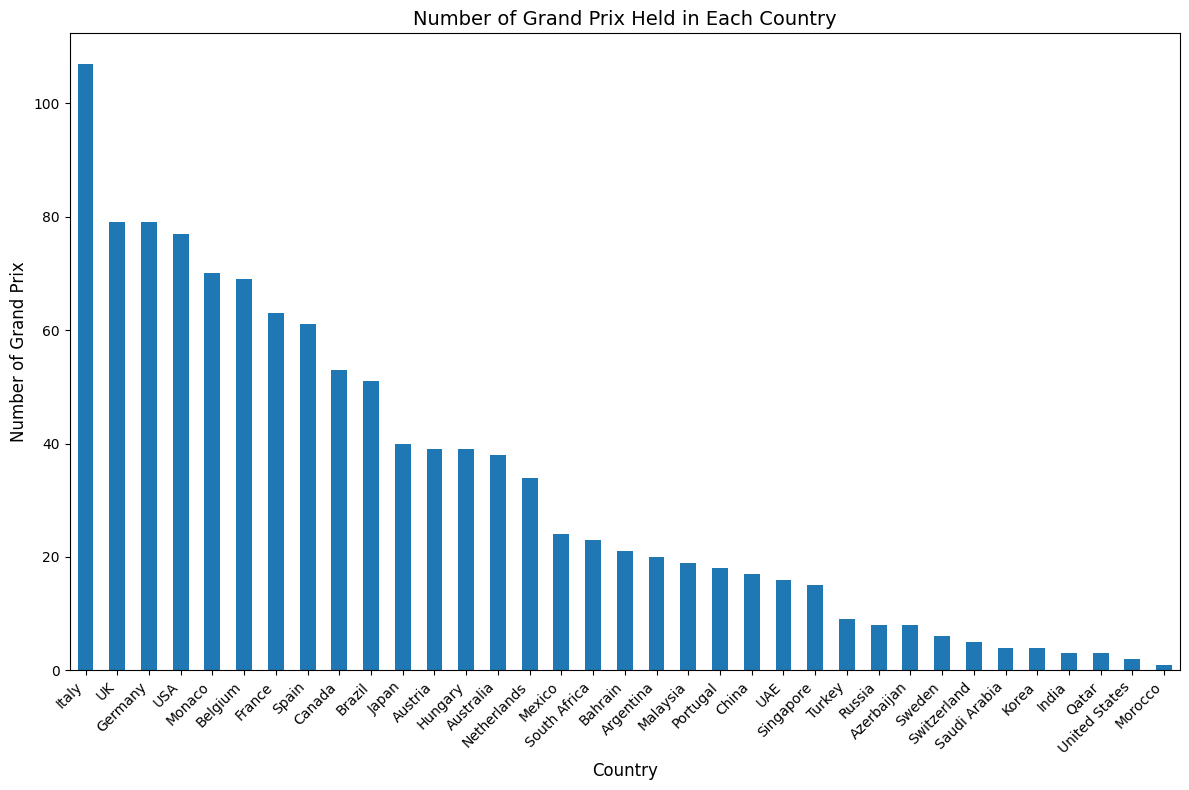

In [24]:
merged_df = pd.merge(races, circuits, left_on='circuitId', right_on='circuitId')
gp_by_country = merged_df['country'].value_counts()

# Plot the results
plt.figure(figsize=(12, 8))
gp_by_country.plot(kind='bar')
plt.title('Number of Grand Prix Held in Each Country', fontsize=14)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Grand Prix', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

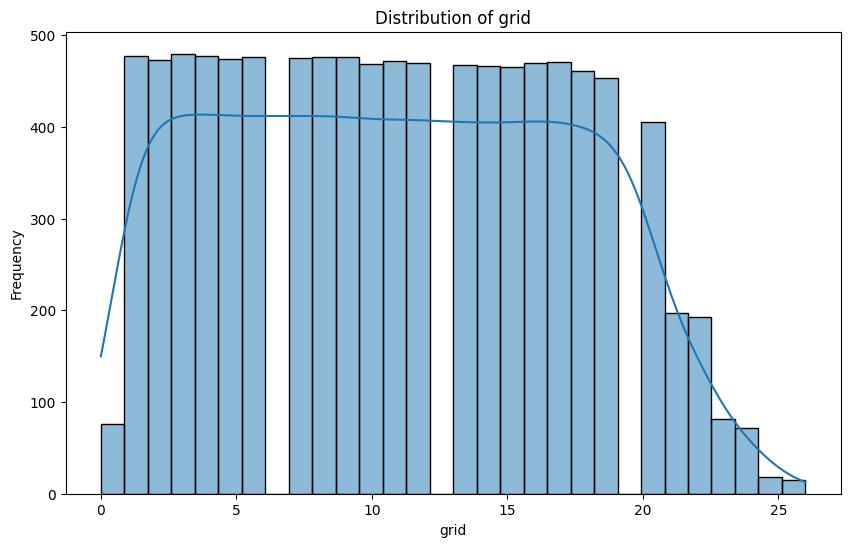

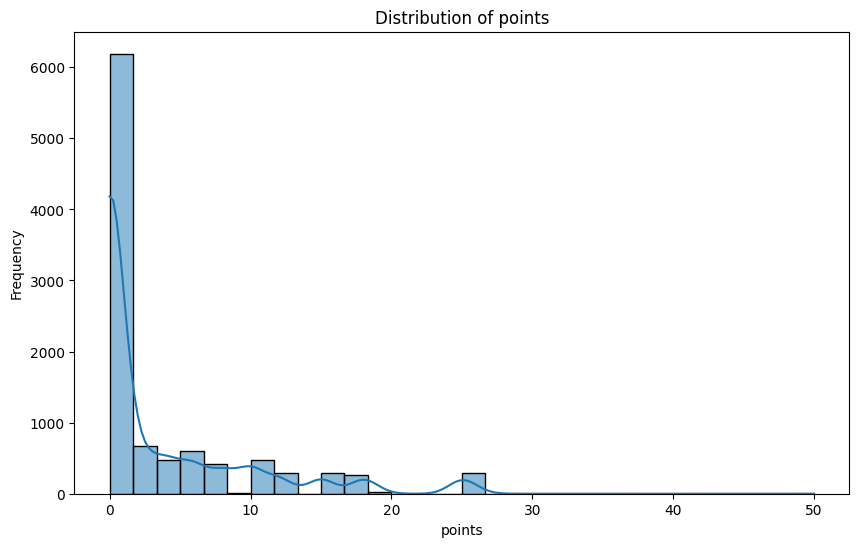

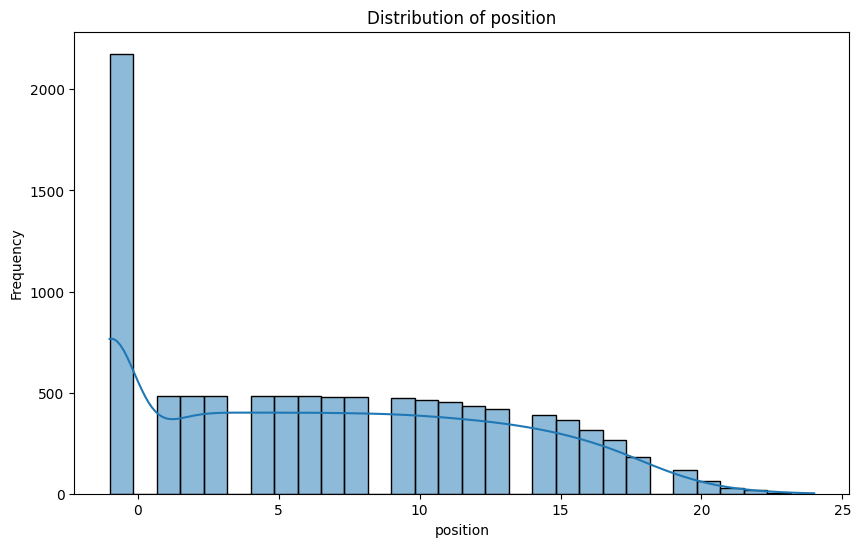

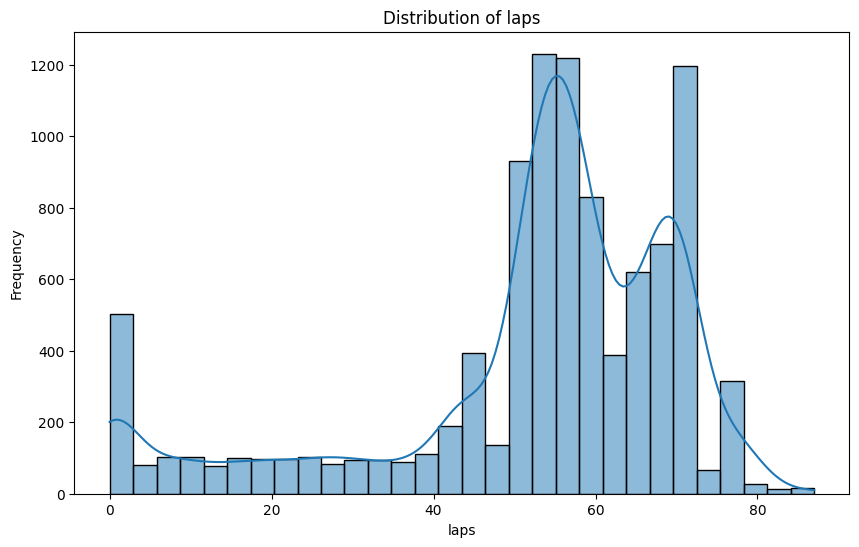

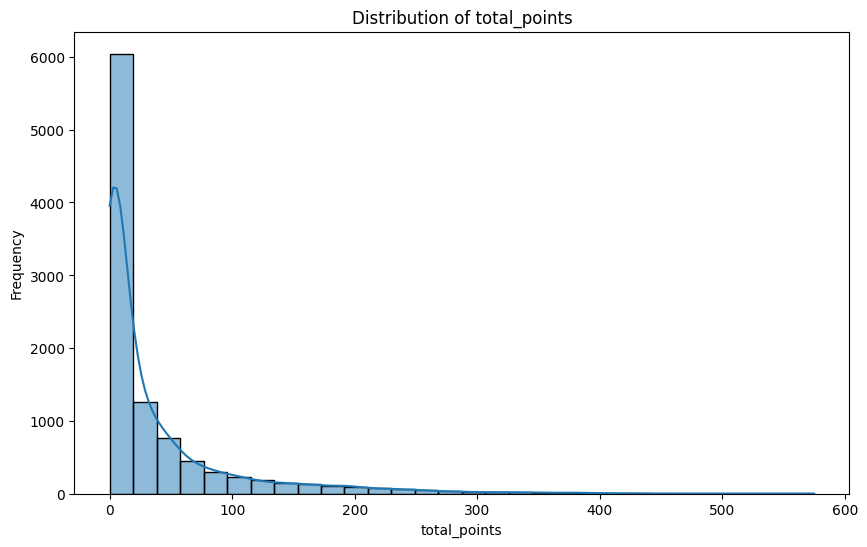

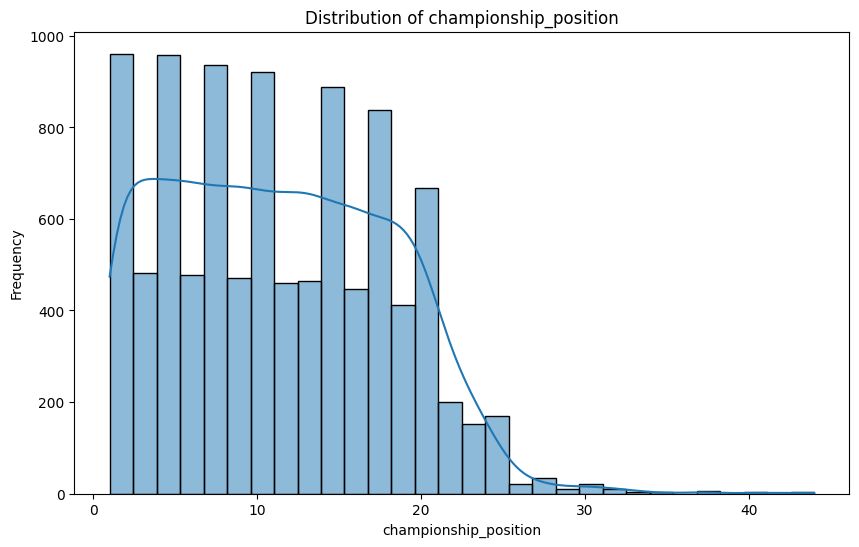

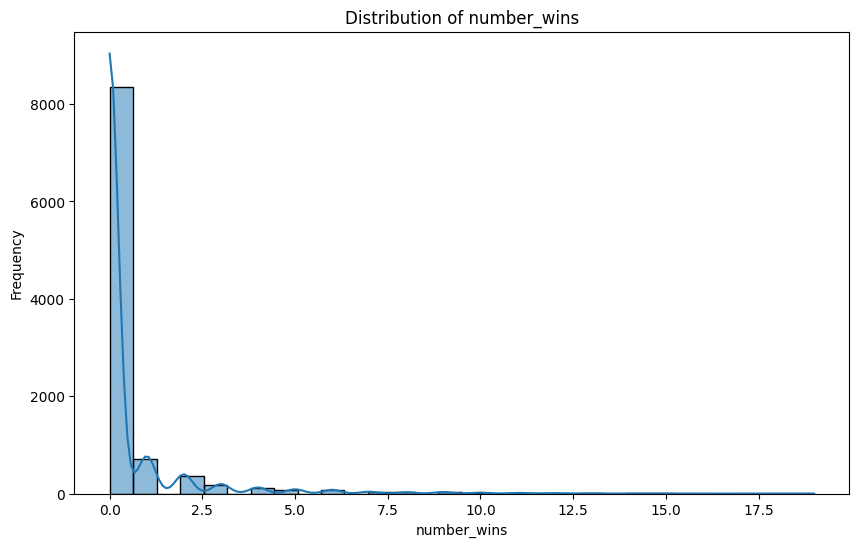

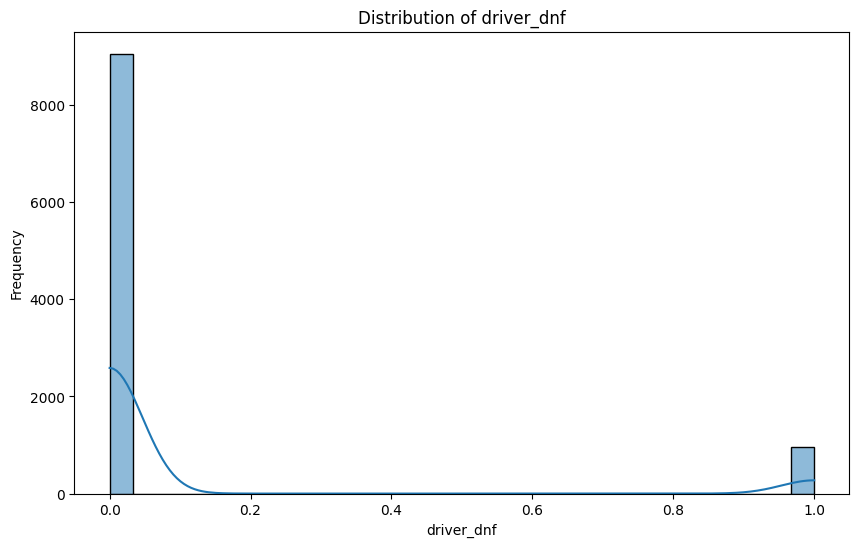

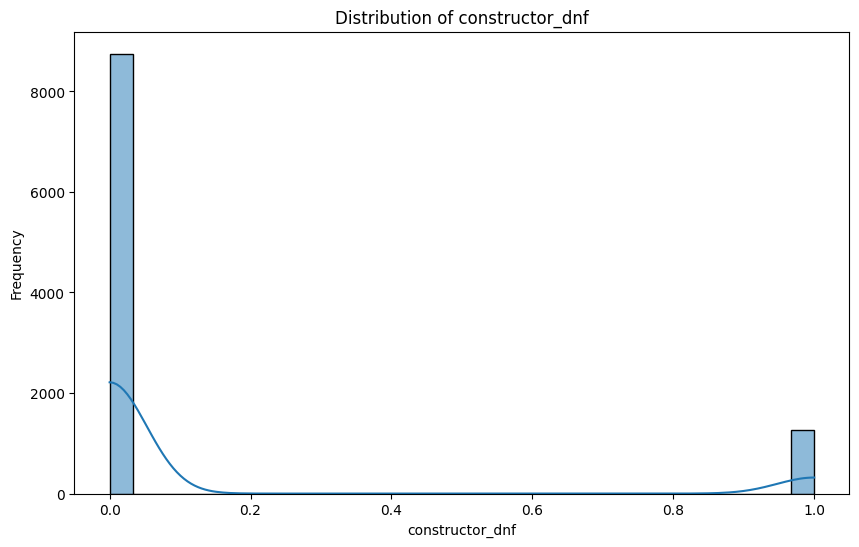

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of numerical columns to plot
numerical_columns = ['grid', 'points', 'position', 'laps', 'total_points', 'championship_position', 'number_wins', 'driver_dnf', 'constructor_dnf']

# Plot histograms and KDEs for numerical variables
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(cleaned_data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

C:\Users\joelc\AppData\Local\Temp\ipykernel_14524\1018033073.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = cleaned_data.corr()


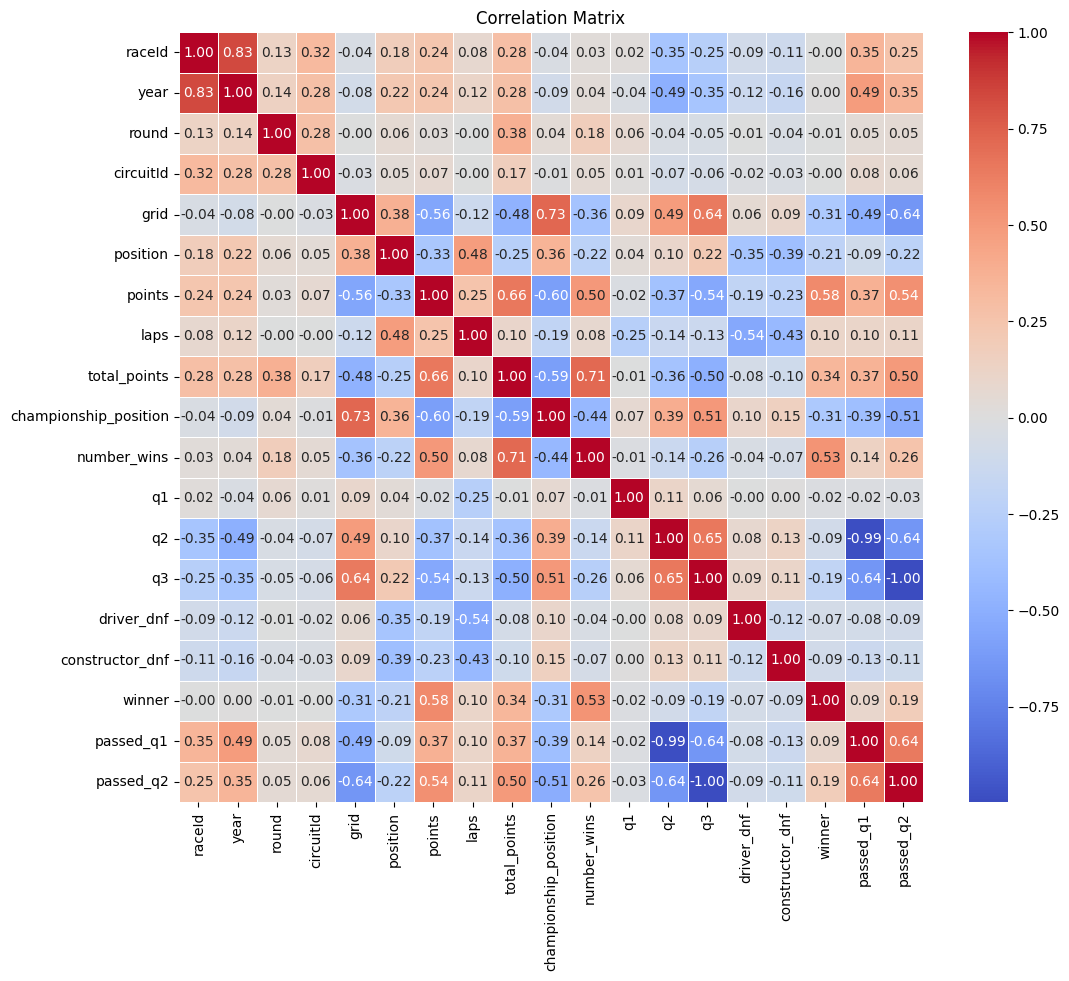

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Explore correlations between numerical variables
correlation_matrix = cleaned_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

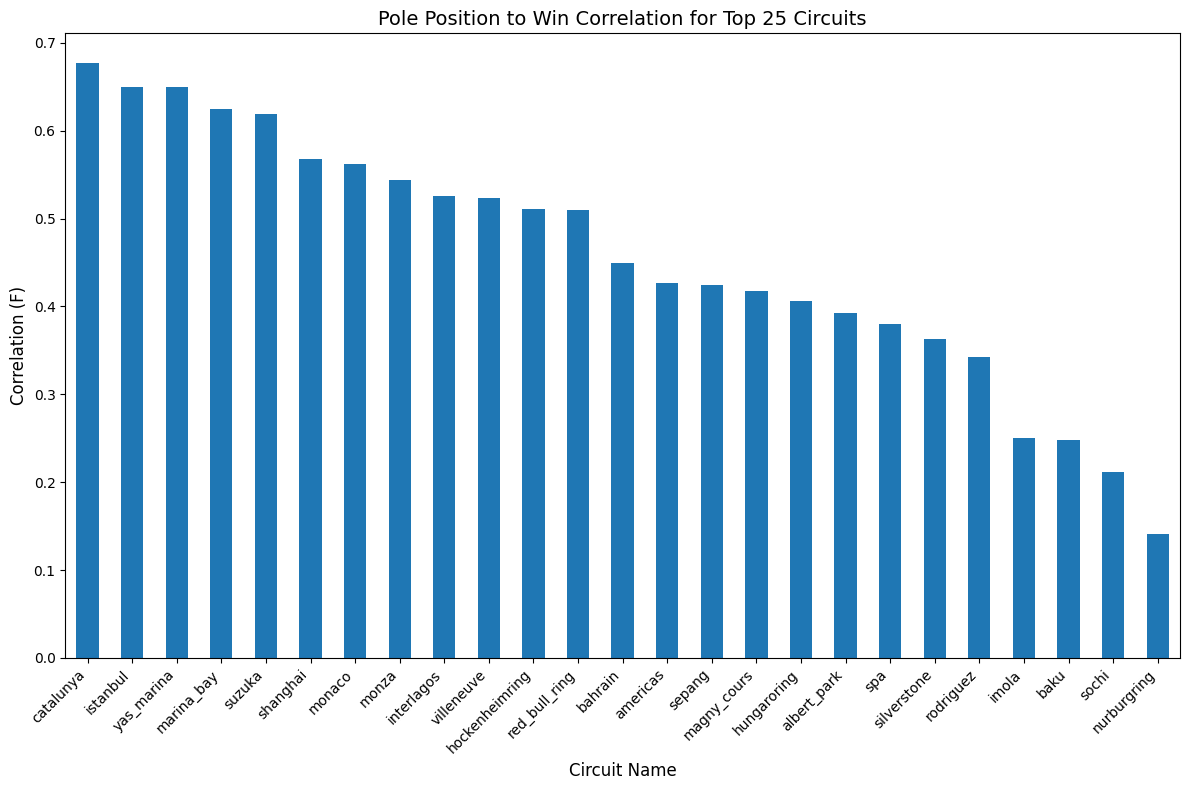

In [27]:
# Identify the 25 most popular circuits based on the number of races
top_circuits = cleaned_data['circuitId'].value_counts().head(25).index

# Filter the data for these circuits
filtered_data = cleaned_data[cleaned_data['circuitId'].isin(top_circuits)]

# Recalculate the correlation for these circuits
correlation_by_circuit = filtered_data.groupby('circuitId').apply(
    lambda x: x['grid'].eq(1).astype(int).corr(x['position'].eq(1).astype(int))
).sort_values(ascending=False)

# Get circuit names from the circuits data
circuit_names = circuits.set_index('circuitId')['circuitRef']

# Map circuit IDs to names for the x-axis
correlation_by_circuit.index = correlation_by_circuit.index.map(circuit_names)

# Plotting the correlation for the 15 most popular circuits
plt.figure(figsize=(12, 8))
correlation_by_circuit.plot(kind='bar')
plt.title('Pole Position to Win Correlation for Top 25 Circuits', fontsize=14)
plt.xlabel('Circuit Name', fontsize=12)
plt.ylabel('Correlation (F)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


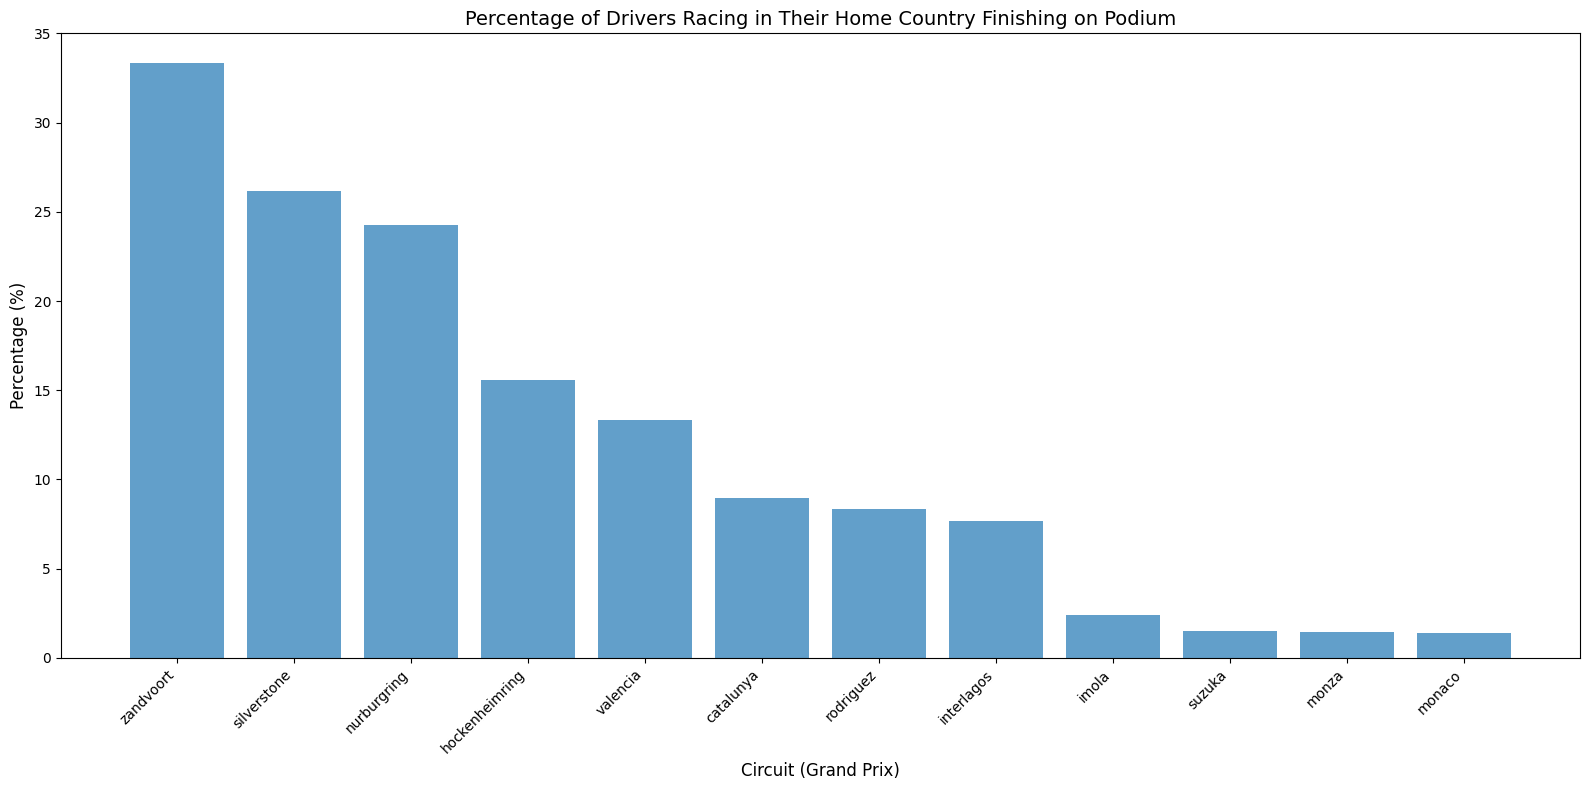

In [28]:
# Step 1: Clean the `position` column to filter podium finishes
cleaned_data_df = cleaned_data[~cleaned_data["position"].isin(["\\N"])]  # Remove invalid entries
cleaned_data_df["position"] = pd.to_numeric(cleaned_data_df["position"])  # Convert to numeric

# Step 2: Map driver nationalities to countries
nationality_to_country = {
    "German": "Germany",
    "Dutch": "Netherlands",
    "British": "UK",
    "Brazilian": "Brazil",
    "Finnish": "Finland",
    "French": "France",
    "Austrian": "Austria",
    "Italian": "Italy",
    "Japanese": "Japan",
    "Australian": "Australia",
    "Portuguese": "Portugal",
    "Monegasque": "Monaco",
    "Belgian": "Belgium",
    "Swiss": "Switzerland",
    "Danish": "Denmark",
    "Canadian": "Canada",
    "Argentine": "Argentina",
    "Spanish": "Spain",
    "Colombian": "Colombia",
    "Czech": "Czech Republic",
    "Malaysian": "Malaysia",
    "Irish": "Ireland",
    "Hungarian": "Hungary",
    "Indian": "India",
    "American": "USA",
    "Polish": "Poland",
    "Russian": "Russia",
    "Venezuelan": "Venezuela",
    "Mexican": "Mexico",
    "Swedish": "Sweden",
    "Indonesian": "Indonesia",
    "New Zealander": "New Zealand",
    "Thai": "Thailand",
}
cleaned_data["mapped_country"] = cleaned_data["driver_nationality"].map(nationality_to_country)

# Step 3: Add a column to indicate podium finishes
cleaned_data["on_podium"] = cleaned_data["position"].isin([1, 2, 3]).astype(int)

# Step 4: Calculate the percentage of podium finishes for drivers in their home country
podium_data = cleaned_data[cleaned_data["on_podium"] == 1]  # Filter podium data

# Group by circuitId and calculate the percentage of podium finishes for drivers in their home country
podium_home_circuit = (
    podium_data.apply(lambda x: x["country"] == x["mapped_country"], axis=1)
    .groupby(podium_data["circuitId"])
    .mean()
    * 100
).sort_values(ascending=False)

# Merge with circuit information to get circuit names and countries
circuits_info = cleaned_data[["circuitId", "country", "circuitRef"]].drop_duplicates()
podium_home_circuit = podium_home_circuit.reset_index(name="percentage")
podium_home_circuit = podium_home_circuit.merge(circuits_info, on="circuitId", how="left")

# Filter to keep only circuits with percentage > 0
podium_home_circuit = podium_home_circuit[podium_home_circuit["percentage"] > 0]

# Sort by percentage and keep only necessary columns
podium_home_circuit = podium_home_circuit.sort_values(by="percentage", ascending=False)

# Plot the results
plt.figure(figsize=(16, 8))
plt.bar(
    podium_home_circuit["circuitRef"], podium_home_circuit["percentage"], alpha=0.7
)
plt.title("Percentage of Drivers Racing in Their Home Country Finishing on Podium", fontsize=14)
plt.xlabel("Circuit (Grand Prix)", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



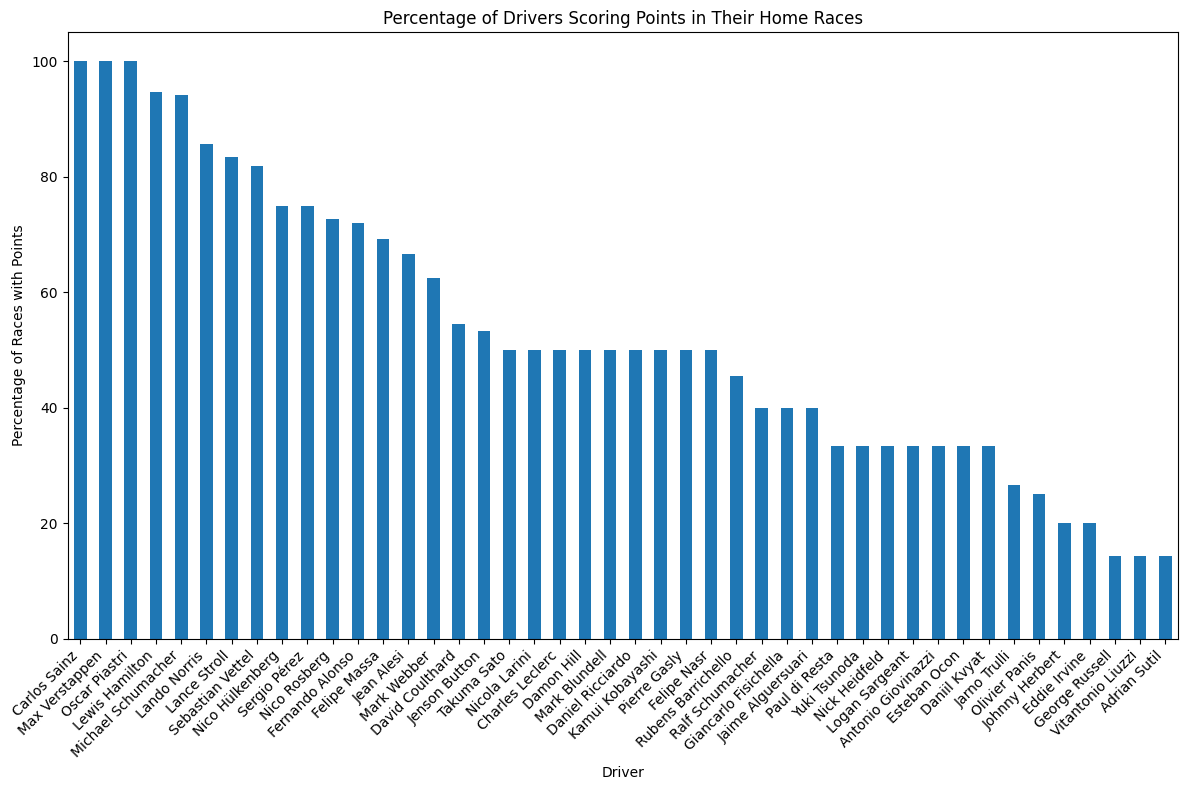

In [29]:
import matplotlib.pyplot as plt

# Filter data for drivers racing in their home country
home_race_data = cleaned_data[cleaned_data['country'] == cleaned_data['mapped_country']]

# Calculate the percentage of races where drivers scored points in their home country
points_in_home_race = home_race_data[home_race_data['points'] > 0].groupby('driver_name').size()
total_home_races = home_race_data.groupby('driver_name').size()
points_percentage_home_race = (points_in_home_race / total_home_races) * 100

# Filter out drivers with 0% points
points_percentage_home_race = points_percentage_home_race[points_percentage_home_race > 0]

# Sort the results in descending order
points_percentage_home_race = points_percentage_home_race.sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(12, 8))
points_percentage_home_race.plot(kind='bar')
plt.title('Percentage of Drivers Scoring Points in Their Home Races')
plt.xlabel('Driver')
plt.ylabel('Percentage of Races with Points')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

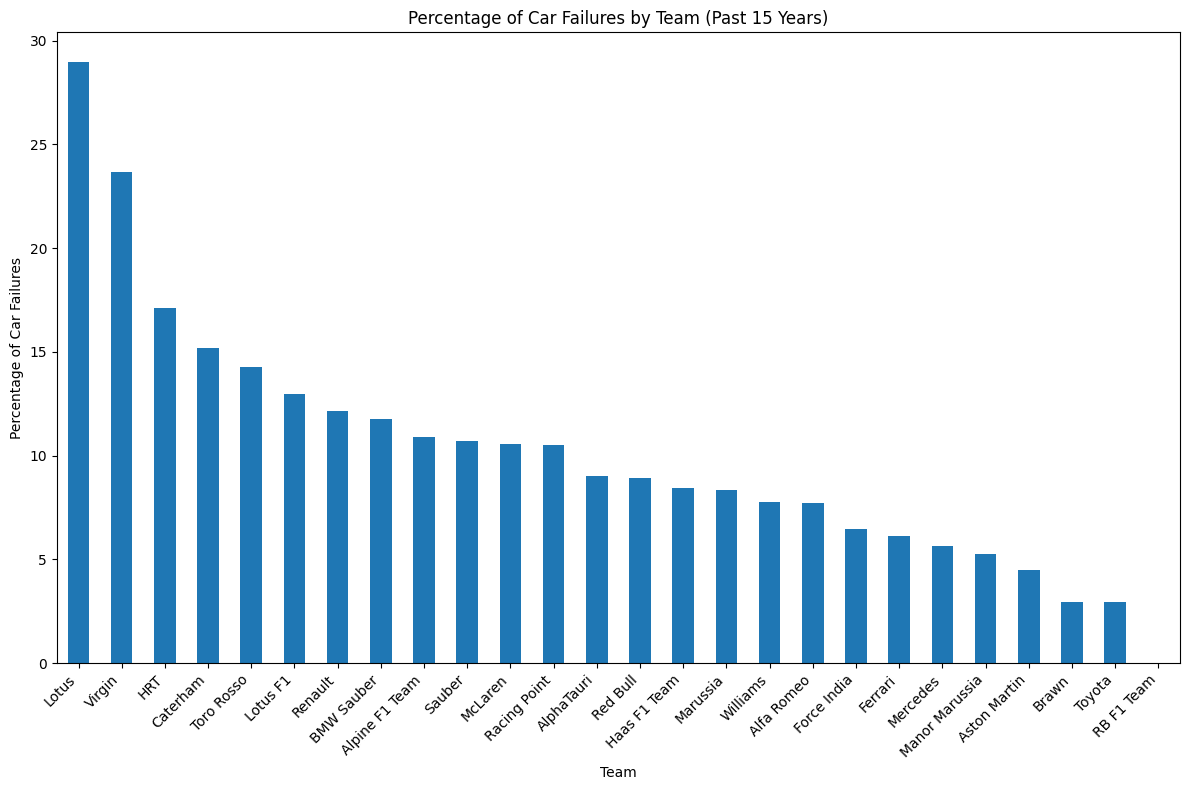

In [30]:
import matplotlib.pyplot as plt

# Filter data for the past 15 years
recent_years = cleaned_data[cleaned_data['year'] >= (cleaned_data['year'].max() - 15)]

# Calculate the total number of races for each team in the past 15 years
total_races_by_team_recent = recent_years['constructor_name'].value_counts()

# Calculate the number of failures for each team in the past 15 years
failures_by_team_recent = recent_years[recent_years['constructor_dnf'] == 1]['constructor_name'].value_counts()

# Calculate the percentage of failures
percentage_failures_by_team_recent = (failures_by_team_recent / total_races_by_team_recent) * 100

# Sort the results in descending order
percentage_failures_by_team_recent = percentage_failures_by_team_recent.sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(12, 8))
percentage_failures_by_team_recent.plot(kind='bar')
plt.title('Percentage of Car Failures by Team (Past 15 Years)')
plt.xlabel('Team')
plt.ylabel('Percentage of Car Failures')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

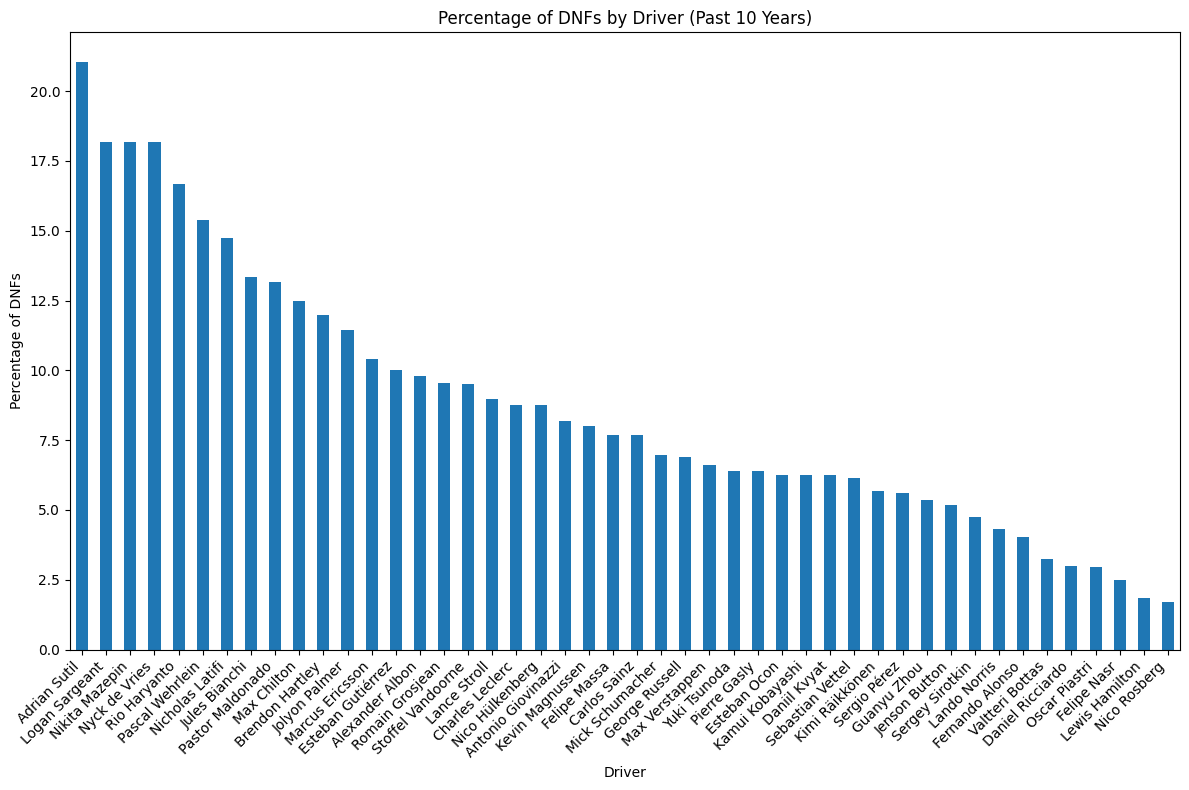

In [31]:
import matplotlib.pyplot as plt

# Filter data for the past 10 years
recent_years = cleaned_data[cleaned_data['year'] >= (cleaned_data['year'].max() - 10)]

# Calculate the total number of races for each driver in the past 10 years
total_races_by_driver_recent = recent_years['driver_name'].value_counts()

# Calculate the number of DNFs for each driver in the past 10 years
dnfs_by_driver_recent = recent_years[recent_years['driver_dnf'] == 1]['driver_name'].value_counts()

# Calculate the percentage of DNFs
percentage_dnfs_by_driver_recent = (dnfs_by_driver_recent / total_races_by_driver_recent) * 100

# Exclude drivers with 0 DNFs
percentage_dnfs_by_driver_recent = percentage_dnfs_by_driver_recent[percentage_dnfs_by_driver_recent > 0]

# Sort the results in descending order
percentage_dnfs_by_driver_recent = percentage_dnfs_by_driver_recent.sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(12, 8))
percentage_dnfs_by_driver_recent.plot(kind='bar')
plt.title('Percentage of DNFs by Driver (Past 10 Years)')
plt.xlabel('Driver')
plt.ylabel('Percentage of DNFs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\joelc\AppData\Local\Temp\ipykernel_14524\2040239020.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winning_drivers['age_at_gp_in_years'] = winning_drivers['age_at_gp_in_days'].astype(int) / 365.25


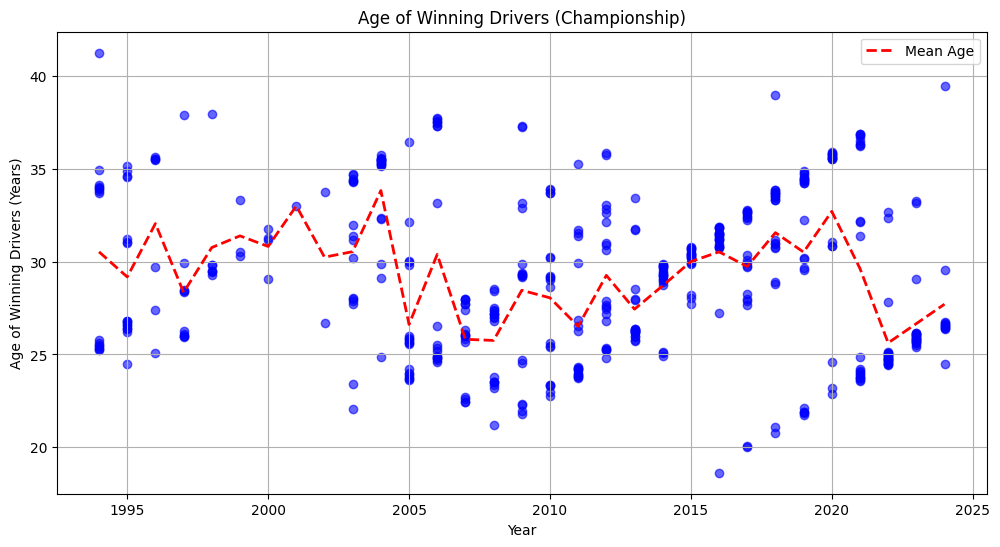

In [32]:
import matplotlib.pyplot as plt

# Filter data for winning drivers
winning_drivers = cleaned_data[cleaned_data['winner'] == 1]

# Calculate the age of the winning drivers in years
winning_drivers['age_at_gp_in_years'] = winning_drivers['age_at_gp_in_days'].astype(int) / 365.25

# Add a trending mean line
mean_age_per_year = winning_drivers.groupby('year')['age_at_gp_in_years'].mean()

plt.figure(figsize=(12, 6))
plt.scatter(winning_drivers['year'], winning_drivers['age_at_gp_in_years'], color='blue', alpha=0.6)
plt.plot(mean_age_per_year.index, mean_age_per_year.values, color='red', linestyle='--', linewidth=2, label='Mean Age')
plt.title('Age of Winning Drivers (Championship)')
plt.xlabel('Year')
plt.ylabel('Age of Winning Drivers (Years)')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
cleaned_data.to_csv('data/cleaned_data_EDA.csv', index=False)